#  CAP 4770 : Data Mining Final Project
## By Hayden Mann and Kyle Rushing
For this project, we decided to use the "Motor Vehicle Collisions - Crashes" Database, a database that records the crash reports from New York City. This information includes when it happened, where it happened, what vehicles were involved, the reported reasons for the crash, and who was injured/killed.
Link to the Database: https://catalog.data.gov/dataset/motor-vehicle-collisions-crashes


In [43]:
# IMPORTS
import mysql.connector as sql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import ast
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer, OrdinalEncoder



# MYSQL CONNECTION
conn = sql.connect(
    host='localhost', 
    user='root', 
    password='SpyD137qKu%F',
    database= 'test',  
    use_pure = True)

cursor = conn.cursor(buffered=True)

In [44]:
# TESTING MYSQL DATABASE CONNECTION
cursor.execute("use test")
for x in cursor:
   print(x)

cursor.execute("show tables")
for x in cursor:
    print(x) 

cursor.execute("select * from crashes limit 10")
for x in cursor:
    print(x) 

query = "select * from crashes limit 10"
df = pd.read_sql(query, conn)
df

('crashes',)
('09/11/2021', '2:39', '', '', '', '', '', 'WHITESTONE EXPRESSWAY', '20 AVENUE', '', 2, 0, 0, 0, 0, 0, 2, 0, 'Aggressive Driving/Road Rage', 'Unspecified', '', '', '', 4455765, 'Sedan', 'Sedan', '', '', '')
('03/26/2022', '11:45', '', '', '', '', '', 'QUEENSBORO BRIDGE UPPER', '', '', 1, 0, 0, 0, 0, 0, 1, 0, 'Pavement Slippery', '', '', '', '', 4513547, 'Sedan', '', '', '', '')
('11/01/2023', '1:29', 'BROOKLYN', '11230', '40.62179', '-73.970024', '(40.62179, -73.970024)', 'OCEAN PARKWAY', 'AVENUE K', '', 1, 0, 0, 0, 0, 0, 1, 0, 'Unspecified', 'Unspecified', 'Unspecified', '', '', 4675373, 'Moped', 'Sedan', 'Sedan', '', '')
('06/29/2022', '6:55', '', '', '', '', '', 'THROGS NECK BRIDGE', '', '', 0, 0, 0, 0, 0, 0, 0, 0, 'Following Too Closely', 'Unspecified', '', '', '', 4541903, 'Sedan', 'Pick-up Truck', '', '', '')
('09/21/2022', '13:21', '', '', '', '', '', 'BROOKLYN BRIDGE', '', '', 0, 0, 0, 0, 0, 0, 0, 0, 'Passing Too Closely', 'Unspecified', '', '', '', 4566131, 'Stati

C:\Users\Hexhu\AppData\Local\Temp\ipykernel_15292\1567263510.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,,,,,,WHITESTONE EXPRESSWAY,20 AVENUE,,...,Unspecified,,,,4455765,Sedan,Sedan,,,
1,03/26/2022,11:45,,,,,,QUEENSBORO BRIDGE UPPER,,,...,,,,,4513547,Sedan,,,,
2,11/01/2023,1:29,BROOKLYN,11230,40.62179,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,,...,Unspecified,Unspecified,,,4675373,Moped,Sedan,Sedan,,
3,06/29/2022,6:55,,,,,,THROGS NECK BRIDGE,,,...,Unspecified,,,,4541903,Sedan,Pick-up Truck,,,
4,09/21/2022,13:21,,,,,,BROOKLYN BRIDGE,,,...,Unspecified,,,,4566131,Station Wagon/Sport Utility Vehicle,,,,
5,04/26/2023,13:30,,,,,,WEST 54 STREET,,,...,Unspecified,,,,4623759,Sedan,Box Truck,,,
6,11/01/2023,7:12,,,,,,HUTCHINSON RIVER PARKWAY,,,...,Driver Inattention/Distraction,,,,4675709,Sedan,Station Wagon/Sport Utility Vehicle,,,
7,11/01/2023,8:01,,,,,,WEST 35 STREET,HENRY HUDSON RIVER,,...,,,,,4675769,Sedan,,,,
8,04/26/2023,22:20,,,,,,,,61 Ed Koch queensborough bridge,...,,,,,4623865,Sedan,Pick-up Truck,,,
9,09/11/2021,9:35,BROOKLYN,11208,40.667202,-73.8665,"(40.667202, -73.8665)",,,1211 LORING AVENUE,...,,,,,4456314,Sedan,,,,


## Data Cleaing
This section of code is dedicated to cleaning the code and preparing it for exploration and modeling. While a .csv file was generated for testing purpose, the data used in exploration and modeling was taken from the cleaned code directly.

In [45]:
query = f"SELECT * FROM CRASHES;"
df = pd.read_sql(query, conn)

# Had trouble importing certain columns in MySQL, so converting all to string for cleaning
df = df.astype(str)
conn.close()

# CLEANING OFFICIALLY BEGINS
df.columns = (
    df.columns
    .str.lower()
    .str.strip()
    .str.replace(" ", "_")
)
df.replace("", np.nan, inplace=True)

df["crash_datetime"] = pd.to_datetime(df["crash_date"] + " " + df["crash_time"], errors="coerce")
df["hour"] = df["crash_datetime"].dt.hour
df["day_of_week"] = df["crash_datetime"].dt.day_name()
df["month"] = df["crash_datetime"].dt.month

df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")

df = df[~(
    df["latitude"].isna() & 
    df["longitude"].isna() & 
    df["on_street_name"].isna()
)]

# combining street name columns
street_cols = ["on_street_name", "cross_street_name", "off_street_name"]
for col in street_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.upper()
        .str.strip()
        .replace("NAN", np.nan)
    )


df["location_string"] = (
    df["on_street_name"].fillna("") + "_" +
    df["cross_street_name"].fillna("") + "_" +
    df["off_street_name"].fillna("")
).str.replace("__", "_").str.strip("_")

df.loc[df["location_string"] == "", "location_string"] = np.nan

for col in ["borough", "zip_code"]:
    df[col] = df.groupby("location_string")[col].transform(lambda x: x.ffill().bfill())

# Combining contributing factors
factorColumns = ["contributing_factor_vehicle_1", "contributing_factor_vehicle_2", "contributing_factor_vehicle_3", "contributing_factor_vehicle_4", "contributing_factor_vehicle_5"]
def combine_factors(row):
    factors = row[factorColumns].dropna().unique()
    return list(factors)

df["all_factors"] = df.apply(combine_factors, axis=1)


# Combining vehicle types
vehicleColumns = ["vehicle_type_code_1", "vehicle_type_code_2", "vehicle_type_code_3", "vehicle_type_code_4", "vehicle_type_code_5"]
def combine_vehicles(row):
    types = [x for x in row[vehicleColumns].dropna()]
    return list(types)

df["vehicle_types"] = df.apply(combine_vehicles, axis=1)


injuries = ["number_of_persons_injured", "number_of_pedestrians_injured", "number_of_cyclist_injured", "number_of_motorist_injured"]
kills = [ "number_of_persons_killed", "number_of_pedestrians_killed", "number_of_cyclist_killed", "number_of_motorist_killed"]

for col in injuries + kills:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

# In case there are any duplicate records
df.drop_duplicates(subset=["collision_id"], inplace=True)


df.drop(columns=["off_street_name","crash_date", "crash_time"], inplace=True, errors="ignore")
print("Cleaned shape:", df.shape)

# Generated a .csv file for testing purposes
df.to_csv("crashes_cleaned.csv", index=False)


df.head()

C:\Users\Hexhu\AppData\Local\Temp\ipykernel_15292\2565397848.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\Hexhu\AppData\Local\Temp\ipykernel_15292\2565397848.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df.groupby("location_string")[col].transform(lambda x: x.ffill().bfill())
C:\Users\Hexhu\AppData\Local\Temp\ipykernel_15292\2565397848.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.

Cleaned shape: (7561, 33)


,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,...,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,crash_datetime,hour,day_of_week,month,location_string,all_factors,vehicle_types
0,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,2,0,0,...,NaN,NaN,NaN,2021-09-11 02:39:00,2,Saturday,9,WHITESTONE EXPRESSWAY_20 AVENUE,"[Aggressive Driving/Road Rage, Unspecified]","[Sedan, Sedan]"
1,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,1,0,0,...,NaN,NaN,NaN,2022-03-26 11:45:00,11,Saturday,3,QUEENSBORO BRIDGE UPPER,[Pavement Slippery],[Sedan]
2,BROOKLYN,11230,40.62179,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,1,0,0,...,Sedan,NaN,NaN,2023-11-01 01:29:00,1,Wednesday,11,OCEAN PARKWAY_AVENUE K,[Unspecified],"[Moped, Sedan, Sedan]"
3,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,0,0,0,...,NaN,NaN,NaN,2022-06-29 06:55:00,6,Wednesday,6,THROGS NECK BRIDGE,"[Following Too Closely, Unspecified]","[Sedan, Pick-up Truck]"
4,BROOKLYN,11201,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,0,0,0,...,NaN,NaN,NaN,2022-09-21 13:21:00,13,Wednesday,9,BROOKLYN BRIDGE,"[Passing Too Closely, Unspecified]",[Station Wagon/Sport Utility Vehicle]


### Data Exploration

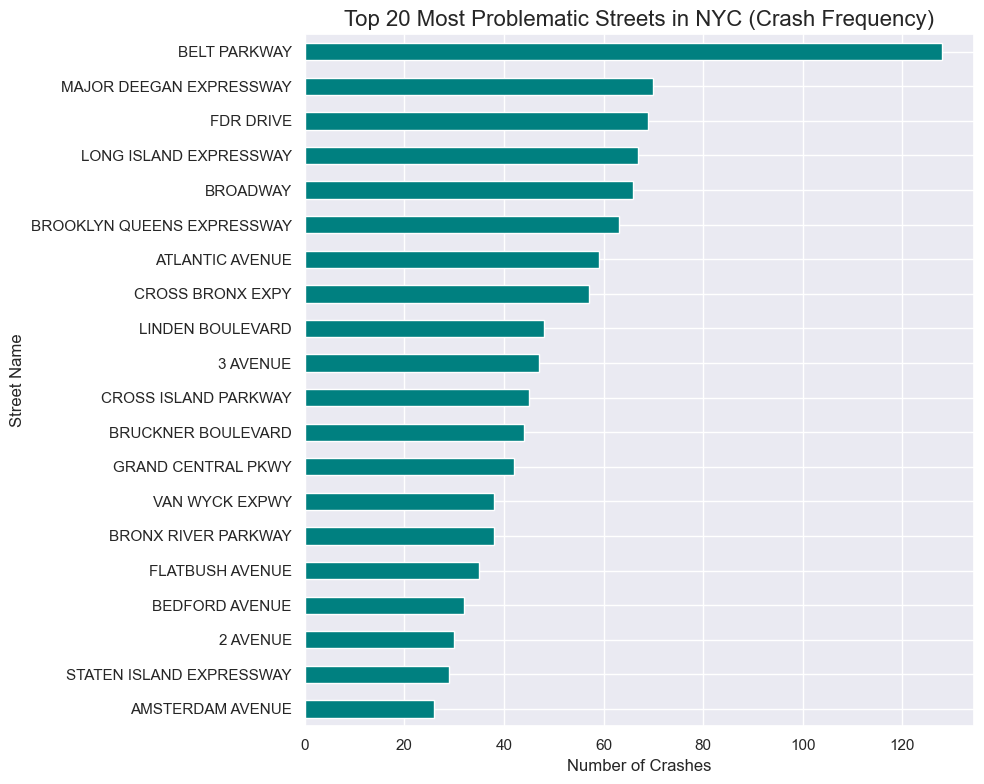

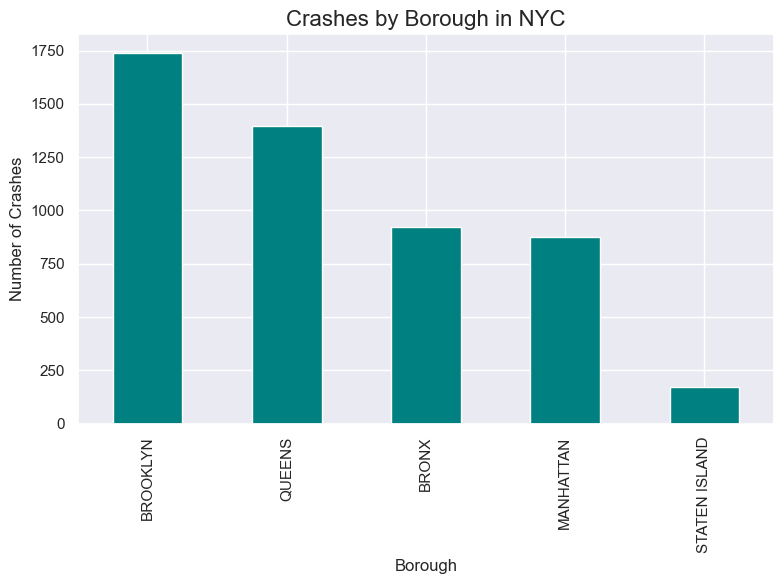

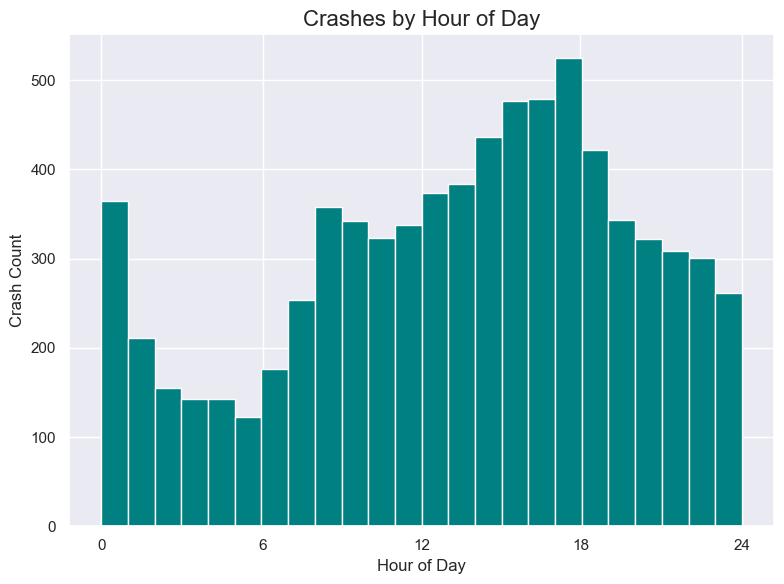

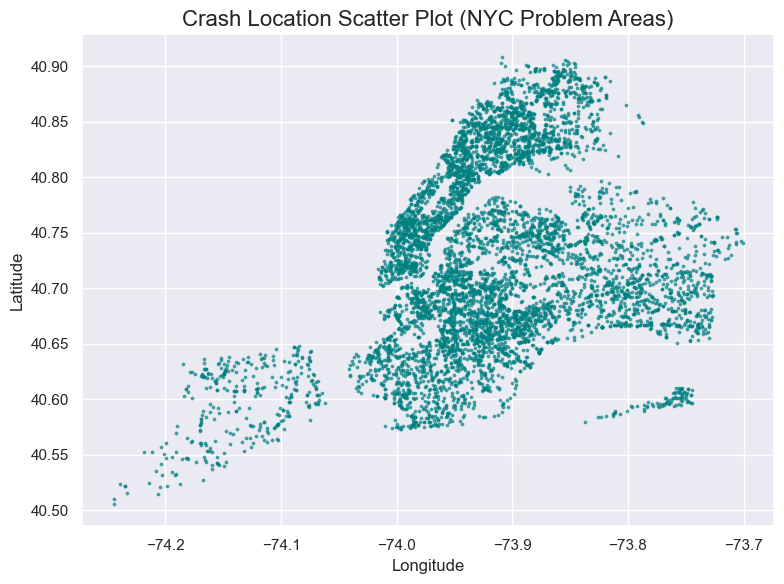

In [70]:
# Convert numeric fields
df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
df["hour"] = pd.to_numeric(df["hour"], errors="coerce")

sns.set_theme(style="darkgrid")

# GRAPH: Top 20 Problematic Streets
plt.figure(figsize=(10,8))
df["on_street_name"].value_counts().head(20).sort_values().plot(kind="barh", color="teal")
plt.title("Top 20 Most Problematic Streets in NYC (Crash Frequency)", fontsize=16)
plt.xlabel("Number of Crashes")
plt.ylabel("Street Name")
plt.tight_layout()
plt.show()

# GRAPH: Crashes by Borough
plt.figure(figsize=(8,6))
df["borough"].value_counts().plot(kind="bar", color="teal")
plt.title("Crashes by Borough in NYC", fontsize=16)
plt.xlabel("Borough")
plt.ylabel("Number of Crashes")
plt.tight_layout()
plt.show()

# GRAPH: Crashes by Hour of Day
plt.figure(figsize=(8,6))
df["hour"].dropna().plot(kind="hist", bins=24, color="teal")
plt.title("Crashes by Hour of Day", fontsize=16)
plt.xlabel("Hour of Day")
plt.xticks([0, 5.8, 11.5, 17.2, 23], [0, 6, 12, 18, 24])
plt.gca().set_xticks([0, 5.8, 11.5, 17.2, 23], minor=False)
plt.grid(True, axis='x', which='major')
plt.ylabel("Crash Count")
plt.tight_layout()
plt.show()


# had to remove zeroes so the scatter plot could more accurately showcase information
df_alt = df[(df["latitude"] != 0) & (df["longitude"] != 0)]

# GRAPH: Crash Location Scatter Plot
plt.figure(figsize=(8,6))
plt.scatter(df_alt["longitude"], df_alt["latitude"], s=3, alpha=0.6, color="teal")
plt.title("Crash Location Scatter Plot (NYC Problem Areas)", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


### Data Modeling: Random Forest

In [ ]:
TOP_N_FACTORS = 30
TOP_N_VEHICLES = 15
CLASSIFICATION_THRESHOLD = 0.40
SEVERITY_COUNT_FEATURES = ['number_of_pedestrians_killed', 'number_of_cyclist_killed', 'number_of_motorist_killed']

# Data Preparation
df['number_of_persons_injured'] = pd.to_numeric(df['number_of_persons_injured'], errors='coerce')
df_predictModel = df.dropna(subset=['number_of_persons_injured'])

df_predictModel['is_injured'] = (df_predictModel['number_of_persons_injured'] >= 1).astype(int)
y = df_predictModel['is_injured']

for col in SEVERITY_COUNT_FEATURES:
    df_predictModel[col] = pd.to_numeric(df_predictModel[col], errors='coerce').fillna(0)


# Feature Engineering
def safe_literal_eval(x):
    try:
        if isinstance(x, str) and x.strip().startswith('['):
            return ast.literal_eval(x)
        return []
    except (ValueError, SyntaxError, TypeError):
        return []

df_predictModel['all_factors_list'] = df_predictModel['all_factors'].apply(safe_literal_eval)
df_predictModel['vehicle_types_list'] = df_predictModel['vehicle_types'].apply(safe_literal_eval)

# Contributing Factors
contributedFactors = MultiLabelBinarizer()
factorMatrix = contributedFactors.fit_transform(df_predictModel['all_factors_list'])
factor_df = pd.DataFrame(factorMatrix, columns=[f'factor_{f.replace(" ", "_")}' for f in contributedFactors.classes_], index=df_predictModel.index)

factor_sums = factor_df.sum().sort_values(ascending=False)
top_factors = factor_sums.head(TOP_N_FACTORS).index.tolist()
factor_df = factor_df[top_factors]

# Vehicle Types
vehicleTypes = MultiLabelBinarizer()
vehicleMatrix = vehicleTypes.fit_transform(df_predictModel['vehicle_types_list'])
vehicle_df = pd.DataFrame(vehicleMatrix, columns=[f'vehicle_{v.replace(" ", "_")}' for v in vehicleTypes.classes_], index=df_predictModel.index)

vehicle_sums = vehicle_df.sum().sort_values(ascending=False)
top_vehicles = vehicle_sums.head(TOP_N_VEHICLES).index.tolist()
vehicle_df = vehicle_df[top_vehicles]


# Had some wierd issues with datetime conversion, this seemed to fix it
if df_predictModel['crash_datetime'].dtype != 'datetime64[ns]':
    df_predictModel['crash_datetime'] = pd.to_datetime(df_predictModel['crash_datetime'], errors='coerce')

df_predictModel = df_predictModel.dropna(subset=['crash_datetime', 'borough'])
df_predictModel['hour'] = df_predictModel['crash_datetime'].dt.hour
df_predictModel['day_of_week'] = df_predictModel['crash_datetime'].dt.dayofweek
df_predictModel['borough'] = df_predictModel['borough'].fillna('UNKNOWN')



X = df_predictModel[['hour', 'day_of_week', 'borough'] + SEVERITY_COUNT_FEATURES].copy()
boroughEncoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X['borough_enc'] = boroughEncoder.fit_transform(X[['borough']])

X = X.join(factor_df)
X = X.join(vehicle_df)

# Final features for the model
FEATURE_COLUMNS = ['hour', 'day_of_week', 'borough_enc'] + SEVERITY_COUNT_FEATURES + top_factors + top_vehicles
X_model = X[FEATURE_COLUMNS].astype(float)
y = df_predictModel['is_injured']

# training
X_train, X_test, y_train, y_test = train_test_split(X_model, y, test_size=0.2, random_state=42, stratify=y)
clf_injury = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1, class_weight='balanced')
clf_injury.fit(X_train, y_train)

y_prob = clf_injury.predict_proba(X_test)[:,1]
y_pred_custom_threshold = (y_prob >= CLASSIFICATION_THRESHOLD).astype(int)

# print results
print(f"\nINJURY RISK MODEL RESULTS")
auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC: {auc:.4f}")
print(classification_report(y_test, y_pred_custom_threshold))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_custom_threshold))

# helper function to use model for predictions
def predict_injury_prob(crash_datetime, borough, factors_list, vehicles_list, 
                        ped_killed, cyc_killed, mot_killed):
    
    Xp_data = {
        'hour': [pd.to_datetime(crash_datetime).hour],
        'day_of_week': [pd.to_datetime(crash_datetime).dayofweek],
        'borough': [borough.upper()],
        'number_of_pedestrians_killed': [ped_killed],
        'number_of_cyclist_killed': [cyc_killed],
        'number_of_motorist_killed': [mot_killed]
    }
    Xp = pd.DataFrame(Xp_data)
    
    Xp['borough_enc'] = boroughEncoder.transform(Xp[['borough']])
    
    knownFactors = set(contributedFactors.classes_)
    factors_input = [f.strip() for f in factors_list if f.strip() in knownFactors]
    factorsMatrix = contributedFactors.transform([factors_input])

    knownVehicles = set(vehicleTypes.classes_)
    vehicles_input = [v.strip() for v in vehicles_list if v.strip() in knownVehicles]
    vehicles_matrix = vehicleTypes.transform([vehicles_input])
    
    final_features = Xp[['hour', 'day_of_week', 'borough_enc'] + SEVERITY_COUNT_FEATURES].copy()
    
    factors_df = pd.DataFrame(factorsMatrix, columns=[f'factor_{f.replace(" ", "_")}' for f in contributedFactors.classes_])
    for col in top_factors:
        final_features[col] = factors_df[col].iloc[0] if col in factors_df.columns else 0

    vehicles_df = pd.DataFrame(vehicles_matrix, columns=[f'vehicle_{v.replace(" ", "_")}' for v in vehicleTypes.classes_])
    for col in top_vehicles:
        final_features[col] = vehicles_df[col].iloc[0] if col in vehicles_df.columns else 0

    X_predict = final_features[FEATURE_COLUMNS].astype(float)
    prob = clf_injury.predict_proba(X_predict)[0,1]

    return prob


# prediction examples
print("\nInjury Prediction 1:", 
      predict_injury_prob(
          crash_datetime="2024-10-25 18:00:00", 
          borough="MANHATTAN", 
          factors_list=["Speeding", "Driver Inattention/Distraction"], 
          vehicles_list=["Sedan", "Station Wagon/Sport Utility Vehicle"],
          ped_killed=0, cyc_killed=0, mot_killed=0
      ))
print("(High Risk: Speeding, Sedan/SUV, but NO fatalities)")
print("\nInjury Prediction 2:", 
      predict_injury_prob(
          crash_datetime="2024-03-01 10:00:00", 
          borough="QUEENS", 
          factors_list=["Following Too Closely"], 
          vehicles_list=["Passenger Vehicle"],
          ped_killed=0, cyc_killed=0, mot_killed=1
      ))
print("(High Risk: Following Too Closely, Passenger Vehicle, with 1 motorist killed)")


INJURY RISK MODEL RESULTS
ROC AUC: 0.7534
              precision    recall  f1-score   support

           0       0.81      0.65      0.72       678
           1       0.51      0.70      0.59       344

    accuracy                           0.67      1022
   macro avg       0.66      0.68      0.65      1022
weighted avg       0.71      0.67      0.68      1022

Confusion matrix:
 [[443 235]
 [104 240]]

Injury Prediction 1: 0.6514732603632711
(High Risk: Speeding, Sedan/SUV, but NO fatalities)

Injury Prediction 2: 0.5205068944975126
(High Risk: Following Too Closely, Passenger Vehicle, with 1 motorist killed)
